# Indentifying Person of Interest with DNN
Angel Martinez-Tenor <br/>
Introduction to Machine Learning - Udacity <br/>
June 2017 <br/>

Goal: Identify Enron employees who may have committed fraud based on the public Enron financial dataset



In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare the data

In [2]:
data_path = 'tools/final_project_dataset.pkl'
df = pd.read_pickle(data_path)
df = pd.DataFrame.from_dict(df, orient='index')
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,1729541,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,257817,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,5243487,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,frank.bay@enron.com,-82782,-201641,63014,...,NaN,NaN,NaN,69,NaN,False,NaN,NaN,145796,NaN


In [3]:
# delete email adresses feature (the only non-numerical one)
if 'email_address' in df.columns:
    df.drop('email_address', axis='columns', inplace=True)

# delete 'TOTAL' row
if 'TOTAL' in df.index:
    df.drop('TOTAL', axis='index', inplace=True) 

# convert dataframe values to numerical
df = df.apply(pd.to_numeric, errors='coerce')

# Reeplace NaN values with mean
df.fillna(df.mean(), inplace=True)

df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955.000000,2902.000000,2.869717e+06,4484442.0,27975000.0,4.175000e+06,-126027.000000,-3.081055e+06,1729541.0,13868.0,47.000000,1.729541e+06,2195.000000,1.520000e+02,65.000000,False,304805.0,1407.000000,1.260270e+05,89822.875
BADUM JAMES P,284087.542553,2073.860465,1.789800e+05,182466.0,27975000.0,1.201773e+06,621892.823529,-5.810498e+05,257817.0,3486.0,64.895349,2.578170e+05,608.790698,4.652767e+05,41.232558,False,746491.2,1176.465116,1.147424e+06,89822.875
BANNANTINE JAMES M,477.000000,566.000000,8.416025e+05,916197.0,27975000.0,1.201773e+06,-560222.000000,-5.104000e+03,5243487.0,56301.0,39.000000,4.046157e+06,29.000000,8.645230e+05,0.000000,False,746491.2,465.000000,1.757552e+06,89822.875
BAXTER JOHN C,267102.000000,2073.860465,1.295738e+06,5634343.0,27975000.0,1.200000e+06,621892.823529,-1.386055e+06,10623258.0,11200.0,64.895349,6.680544e+06,608.790698,2.660303e+06,41.232558,False,1586055.0,1176.465116,3.942714e+06,89822.875
BAY FRANKLIN R,239671.000000,2073.860465,2.604550e+05,827696.0,27975000.0,4.000000e+05,-82782.000000,-2.016410e+05,63014.0,129142.0,64.895349,2.959559e+06,608.790698,6.900000e+01,41.232558,False,746491.2,1176.465116,1.457960e+05,89822.875


In [4]:
#my_data.dtypes
df.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,1.450000e+02,145.000000,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,145.000000,1.450000e+02,145.000000,1.450000e+02,145.000000,1.450000e+02,145.000000,1.450000e+02,145.000000
mean,2.840875e+05,2073.860465,8.416025e+05,2.623421e+06,2.797500e+07,1.201773e+06,6.218928e+05,-5.810498e+05,3.352073e+06,54192.010638,64.895349,2.959559e+06,608.790698,4.652767e+05,41.232558,7.464912e+05,1176.465116,1.147424e+06,89822.875000
std,1.423492e+05,1984.277209,6.535536e+05,8.769015e+06,5.466237e+06,1.074564e+06,1.281843e+06,5.382125e+05,6.062259e+06,37054.424110,66.825751,4.582875e+06,1414.457862,1.104756e+06,76.885708,5.752783e+05,905.295990,1.948358e+06,13269.067105
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-1.787380e+06,-3.504386e+06,-4.409300e+04,148.000000,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3285.000000
25%,2.396710e+05,904.000000,8.416025e+05,5.511740e+05,2.797500e+07,7.000000e+05,6.218928e+05,-5.810498e+05,5.974610e+05,33785.000000,25.000000,7.573010e+05,36.000000,2.630000e+03,6.000000,5.407510e+05,589.000000,3.605280e+05,89822.875000
50%,2.840875e+05,2073.860465,8.416025e+05,1.321557e+06,2.797500e+07,1.201773e+06,6.218928e+05,-5.810498e+05,1.691366e+06,54192.010638,64.895349,2.218275e+06,608.790698,4.011300e+05,41.232558,7.464912e+05,1176.465116,6.989200e+05,89822.875000
75%,2.840875e+05,2073.860465,8.416025e+05,2.623421e+06,2.797500e+07,1.201773e+06,6.218928e+05,-5.810498e+05,3.352073e+06,54192.010638,64.895349,2.959559e+06,608.790698,4.652767e+05,41.232558,7.464912e+05,1176.465116,1.147424e+06,89822.875000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,8.152500e+07,8.000000e+06,1.545629e+07,-8.330000e+02,4.911008e+07,228763.000000,528.000000,3.434838e+07,14368.000000,1.035973e+07,609.000000,5.145434e+06,5521.000000,1.476169e+07,137864.000000


## Checking out the data

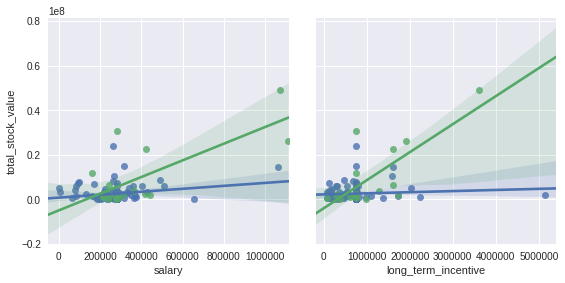

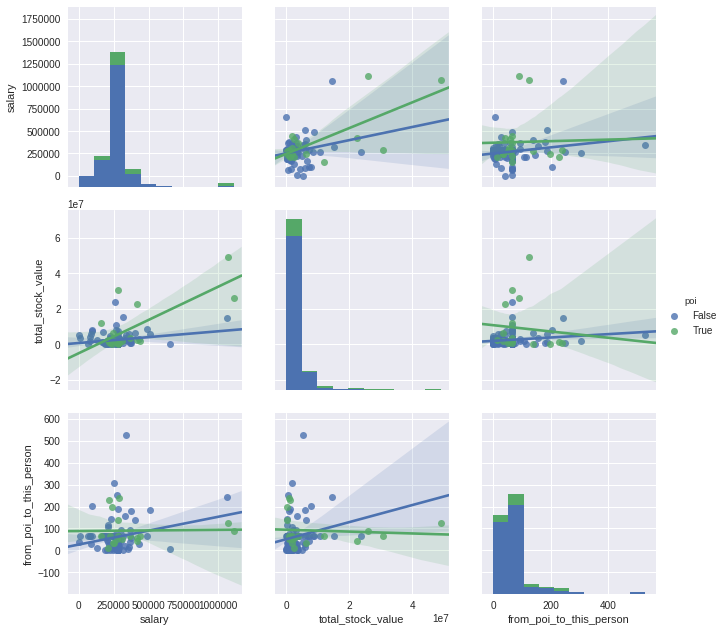

In [5]:
# df.plot.scatter(x='salary', y='total_stock_value')
# df.plot.scatter(x='long_term_incentive', y='total_stock_value')

# sns.lmplot(x="salary", y="total_stock_value", hue='poi', data=df)
# sns.lmplot(x="long_term_incentive", y="total_stock_value", hue='poi', data=df)

g = sns.PairGrid(df, y_vars=["total_stock_value"], x_vars=["salary", "long_term_incentive"], hue='poi',size=4)
g.map(sns.regplot)

sns.pairplot(df, hue='poi', vars=['salary', 'total_stock_value', 'from_poi_to_this_person'], kind='reg', size=3)

### Dummy variables

In [6]:
# Process categorical variables 
dummy_fields = []
dummy_fields = [d for d in dummy_fields if d in df]

dummies = [pd.get_dummies(df[d]) for d in dummy_fields]
df = df.join(dummies)
df = df.drop(dummy_fields, axis='columns')

### Tune selected features

In [7]:
fields_to_drop = []
data = df.drop(fields_to_drop, axis=1)
# filtered dataset now in 'data'

### Scaling target variables
The scaling factors are saved so we can go backwards when we use the network for predictions.

In [8]:
# here all features execpt for the target 'poi' are continuous variable
quant_features = list(data.drop('poi', axis=1)) 

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in quant_features:
    mean, std = data[f].mean(), data[f].std()
    scaled_features[f] = [mean, std]
    data.loc[:, f] = (data[f] - mean)/std

data.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,-0.576979,0.417351,3.103211e+00,0.212227,0.0,2.766914e+00,-5.834724e-01,-4.645015,-0.267645,-1.088237,-2.677912e-01,-0.268394,1.121426e+00,-4.210202e-01,0.309127,False,-0.767778,0.254651,-0.524235,0.0
BADUM JAMES P,0.000000,0.000000,-1.013876e+00,-0.278361,0.0,-2.166744e-16,-1.816374e-16,0.000000,-0.510413,-1.368420,-2.126554e-16,-0.589530,-8.037485e-17,-5.268824e-17,0.000000,False,0.000000,0.000000,0.000000,0.0
BANNANTINE JAMES M,-1.992358,-0.759904,-1.781267e-16,-0.194688,0.0,-2.166744e-16,-9.221995e-01,1.070109,0.311998,0.056916,-3.875055e-01,0.237100,-4.099031e-01,3.613886e-01,-0.536284,False,0.000000,-0.785892,0.313150,0.0
BAXTER JOHN C,-0.119323,0.000000,6.948710e-01,0.343359,0.0,-1.650040e-03,-1.816374e-16,-1.495701,1.199418,-1.160240,-2.126554e-16,0.811932,-8.037485e-17,1.986887e+00,0.000000,False,1.459405,0.000000,1.434690,0.0
BAY FRANKLIN R,-0.312025,0.000000,-8.892117e-01,-0.204781,0.0,-7.461378e-01,-5.497358e-01,0.704942,-0.542547,2.022700,-2.126554e-16,0.000000,-8.037485e-17,-4.210953e-01,0.000000,False,0.000000,0.000000,-0.514088,0.0


### Splitting the data into training, testing, and validation sets

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,  test_size=0.3, random_state=9)

# Separate the data into features and targets (x=features, y=targets)
target_fields = ['poi']
x_train, y_train_nc = train.drop(target_fields, axis=1).values, train[target_fields].values
x_test, y_test_nc = test.drop(target_fields, axis=1).values, test[target_fields].values
# _nc: non-categorical yet

# no validation set; categorical_crossentropy will be used here

### One-hot encoding

In [10]:
import keras

# One-hot encoding the output 
num_classes = 2
y_train = keras.utils.to_categorical(y_train_nc, num_classes)
y_test = keras.utils.to_categorical(y_test_nc, num_classes)
print(x_train.shape ,y_train.shape)
print(x_test.shape,y_test.shape)

Using TensorFlow backend.


(101, 19) (101, 2)
(44, 19) (44, 2)


## Deep Neural Network
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 19)                380       
_________________________________________________________________
dropout_2 (Dropout)          (None, 19)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 40        
Total params: 420.0
Trainable params: 420.0
Non-trainable params: 0.0
_________________________________________________________________
Training: loss: 0.361 ... Training Accuracy: 0.911


(0.7, 0.95)

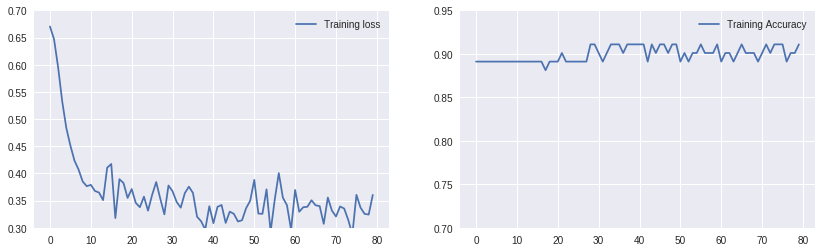

In [13]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
keras.optimizers.Adam
#from keras.layers.advanced_activations import LeakyReLU

nodes = x_train.shape[1]

weights = keras.initializers.RandomNormal(stddev=0.00001)

model = Sequential()
model.add(Dense(nodes, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = 'zero'))
model.add(Dropout(.5))
model.add(Dense(2,activation='softmax',
               kernel_initializer = weights,
               bias_initializer = 'zero'))


# TODO: Compile the model using a loss function and an optimizer.
# opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt = keras.optimizers.adam(lr=0.000001)
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, epochs=80, batch_size=16, verbose=0)

print("Training: loss: {:.3f} ... Training Accuracy: {:.3f}".format(
    history.history['loss'][-1], history.history['acc'][-1]))

plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.legend()
plt.ylim(ymin=0.3, ymax=0.7)
plt.subplot(122)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.legend()
plt.ylim(ymin=0.7, ymax=0.95)

## Evaluating the model

In [14]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: {:.4f}".format(score[1]))

32/44 [====================>.........] - ETA: 0sAccuracy: 0.8636
